# TP 4 Regression logistique avec régularisation
Dans ce TP, nous aimerions faire une classification binaire en utilisant la régression.

Pour ce faire, nous étudierons un ensemble de données avec la variable  (y) representant la commercialisation d'un profuit et les caractéristiques (X) representant les résultat des tests de qualité test 1 et test 2 du produit.

La prédiction se fera avec l'agorithme de descente du gradient avec régularisation.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
print(data.shape)
print(data[:5])

(118, 3)
[[ 0.051267  0.69956   1.      ]
 [-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]]


Dans ces données (data), la première colonne represente la première note, la deuxieme colonne la deuxième note et la troisième colonne represente la commercialisation (1 oui 0 non).

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,0:2]))
y = data[:, 2];
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (118, 3)  y  (118, 1)


# Transformation de données
Dans cette partie, nous aimerions transformer nos données afin d'avoir une fonction polynomiale de degrée 6.

La fonction sera:

$x_0=1$

$x_1=x_1$

$x_2=x_2$

$x_3={x_1}^2$

$x_4={x_1}x_2$

$x_5={x_2}^2$

$x_6={x_1}^3$

$x_7={x_1}^2 x_2$

$x_8= x_1 {x_2}^2$

$x_9= {x_2}^3$

...


Pour un polynme de degrée 6 à 2 variables nous aurons 28 caracteristiques

**Question**: comment avons nous trouvé ce chiffre?

**Astuce**: référez vous aux probabilités

Si on calcule la somme des nombre de caracteristique qu'on va obtenire en utilisent les 2 variables pour chaque degres on obtien 28
par exemple pour le degres 3 on a:
- ${x_1}³{x_2}⁰$
- ${x_1}²{x_2}¹$
- ${x_1}¹{x_2}²$
- ${x_1}⁰{x_2}³$

on a 4 combinaisons

on est entrain de calculer le nombre de combinaisons dans le samme des puissance egale a un degres K.
p(k) = p(4) = 4*1 (4 parceque on a la possiblilité entre [${{x_1}³,{x_1}²,{x_1}¹,{x_1}⁰}$] est pour chaque element de cet ensemble il existe un seul cas dans [${{x_2}³,{x_2}²,{x_2}¹,{x_2}⁰}$] qui on peut avoir le degres 4)

on applique la meme chose pour chaque degres de 0 a 6 puis on fais la somme
on obtient nb_caracteristique = 7+6+4+3+2+1 = 28

In [5]:
def mapping(X):
    
    cols = 28
    degree=7
    outX= np.ones((X.shape[0],cols))
    X1=X[:,1]
    X2=X[:,2]
    k=0
    for i in range(degree):
        for j in range(i+1):
            outX[:, k] = np.power(X1,i-j)*(np.power(X2,j));
            k=k+1
    return outX    


In [6]:
X2=mapping(X)
print(X2.shape)
print(X2[:5])

(118, 28)
[[ 1.00000000e+00  5.12670000e-02  6.99560000e-01  2.62830529e-03
   3.58643425e-02  4.89384194e-01  1.34745327e-04  1.83865725e-03
   2.50892595e-02  3.42353606e-01  6.90798869e-06  9.42624411e-05
   1.28625106e-03  1.75514423e-02  2.39496889e-01  3.54151856e-07
   4.83255257e-06  6.59422333e-05  8.99809795e-04  1.22782870e-02
   1.67542444e-01  1.81563032e-08  2.47750473e-07  3.38066048e-06
   4.61305487e-05  6.29470940e-04  8.58939846e-03  1.17205992e-01]
 [ 1.00000000e+00 -9.27420000e-02  6.84940000e-01  8.60107856e-03
  -6.35227055e-02  4.69142804e-01 -7.97681228e-04  5.89122275e-03
  -4.35092419e-02  3.21334672e-01  7.39785525e-05 -5.46363780e-04
   4.03513411e-03 -2.98012201e-02  2.20094970e-01 -6.86091891e-06
   5.06708697e-05 -3.74226408e-04  2.76382476e-03 -2.04120477e-02
   1.50751849e-01  6.36295342e-07 -4.69931780e-06  3.47065055e-05
  -2.56322636e-04  1.89305413e-03 -1.39810280e-02  1.03255971e-01]
 [ 1.00000000e+00 -2.13710000e-01  6.92250000e-01  4.56719641e-0

# Descente du Gradient : Préparation des fonctions

0- Fonction mpgistique (Sigmoid)

In [7]:
def sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z))

def Sigmoid(X,theta):
    K = np.dot(X,theta)
    H = 1/(1+np.exp(-K))
    return H;
 

In [8]:
k=sigmoid(-10)
k

4.5397868702434395e-05

1- Calcul du coût

Cette fonction servira à calculer le cout $J(\theta_0,\theta_1)$

Elle prendra l'ensemble de données d'apprentissage en entrée ainsi que les paramètres définis initialement

In [9]:
def computeCost(X, y, theta,lambdaa):
    h = Sigmoid(X,theta)
    return -1/X.shape[0] * ((y*np.log(h)).sum() + ((1-y)*np.log(1-h)).sum()) + (lambdaa/(2*X.shape[0]))*np.power(theta,2).sum()

2- Fonction de la descente du gradient

Cette fonction mettra à jour les paramètres $\theta_0,\theta_1$ jusqu'à convergence: atteinte du nombre d'itérations max, ou dérivée assez petite.

In [10]:
def gradientDescent(X, y, theta, alpha,lambdaa, iterations):
    vals = []
    mpX = mapping(X)
    for i in range(iterations):
        vals = vals + [theta[0]+0,theta[1]+0,theta[2]+0,computeCost(mpX,y,theta,lambdaa)]
        theta = np.subtract(theta*(1-alpha*lambdaa/mpX.shape[0]), alpha/X.shape[0]*np.sum(np.dot(np.transpose(mpX), Sigmoid(mpX,theta)- y),axis=1).reshape(-1,1))
    return theta,vals


def gradientDescent_(X, y, theta, alpha=0.01,lambdaa=1 ,iterations=150):
    # garder aussi le cout à chaque itération 
    # pour afficher le coût en fonction de theta0 et theta1
    i = 0
    temp_theta = np.zeros((theta.shape))
    couts_history, theta_history = [],[]
    theta1 = theta
    
    while (iterations>i):
        
        tab_h = 1/(1 + np.exp(- (theta1.transpose().dot(X.transpose())))) #calculer 
        
        tab_h = tab_h.reshape(len(y))
       
        for j in range(len(theta)):
            
            temp_theta[j] = theta1[j] - alpha*(((((tab_h - y)*X[:,j]).sum())/(len(y))) + ((lambdaa/len(y)*theta1[j])))
            
        theta1 = temp_theta
        
        couts_history.append(computeCost(X,y,lambdaa,temp_theta))
        
        theta_history.append([theta1[0][0],theta1[1][0]])
        
        i+=1
    return theta1, couts_history, theta_history


# Descente du Gradient : Appel des fonctions

Initialisation de $\theta_0$ et $\theta_1$

In [11]:
n=X2.shape[1]

theta = np.ones((n, 1))
theta.shape

(28, 1)

Calculer le cout initial

In [12]:
initialCost=computeCost(mapping(X), y, theta,1)
print(initialCost)

2.1390856028014507


Appel des la fonction de calcul du gradient

In [13]:
# paramètres
iterations = 15000
alpha = 0.01
# paramètre de regression
lambdaa = 1
# Appel
theta,vals = gradientDescent(X, y, theta, alpha, lambdaa,iterations)
computeCost(mapping(X), y, theta,lambdaa)

0.5388238554710275

In [14]:
for l in np.linspace(1,0,5):
    thet,_ = gradientDescent(X, y, np.ones((28, 1)), alpha, l,iterations)
    print("lambda = ",l," --> cost = ",computeCost(mapping(X), y, thet,l))

lambda =  1.0  --> cost =  0.5388238554710275
lambda =  0.75  --> cost =  0.5226002664633325
lambda =  0.5  --> cost =  0.5018472130961597
lambda =  0.25  --> cost =  0.4741310933646718
lambda =  0.0  --> cost =  0.43499307463281145


Traçage de la fonction du coût

Notons que $\theta^T  x$ est équivalent à $X  \theta $ où $X= \begin{pmatrix}
..(x^{(1)})^T..\\
..(x^{(2)})^T..\\
.\\
.\\
.\\
..(x^{(m)})^T..
\end{pmatrix} $

# Dessin de la limite de decision (Descision Boundary)
Dans cette partie, nous aimerions dessiner la ligne separatrice d nos données

In [15]:
def drawCircle():
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    z = np.zeros((u.size, v.size))
    
    for i, ui in enumerate(u):
        for j, vj in enumerate(v):
            z[i, j] = np.dot(mapping(np.array([[1,u[i],v[j]]])), theta)

    z = np.transpose(z)
    plt.contour(u, v, z, levels=[0])

# Classification (Prédiction)
Ici il serait interessant de calculer la prédiction en utilisant un seuil
i.e. si h>seuil alors classe =1 sinon classe = 0

In [16]:
def predict(X,theta,seuil):
    S = Sigmoid(mapping(X),theta)
    S[S>=seuil] = 1
    S[S<seuil] = 0
    return S

In [17]:
pred = predict(X,theta,0.5)

In [18]:
print("lambda == 1")
for s in np.linspace(0,1,11):
    print("Seuil :",s," ---> Erreurs : ",(predict(X,theta,s)!=y).sum())
print("lambda == 0")
for s in np.linspace(0,1,11):
    print("Seuil :",s," ---> Erreurs : ",(predict(X,thet,s)!=y).sum())

lambda == 1
Seuil : 0.0  ---> Erreurs :  60
Seuil : 0.1  ---> Erreurs :  57
Seuil : 0.2  ---> Erreurs :  48
Seuil : 0.30000000000000004  ---> Erreurs :  38
Seuil : 0.4  ---> Erreurs :  23
Seuil : 0.5  ---> Erreurs :  21
Seuil : 0.6000000000000001  ---> Erreurs :  26
Seuil : 0.7000000000000001  ---> Erreurs :  45
Seuil : 0.8  ---> Erreurs :  58
Seuil : 0.9  ---> Erreurs :  58
Seuil : 1.0  ---> Erreurs :  58
lambda == 0
Seuil : 0.0  ---> Erreurs :  60
Seuil : 0.1  ---> Erreurs :  51
Seuil : 0.2  ---> Erreurs :  39
Seuil : 0.30000000000000004  ---> Erreurs :  28
Seuil : 0.4  ---> Erreurs :  20
Seuil : 0.5  ---> Erreurs :  21
Seuil : 0.6000000000000001  ---> Erreurs :  23
Seuil : 0.7000000000000001  ---> Erreurs :  34
Seuil : 0.8  ---> Erreurs :  49
Seuil : 0.9  ---> Erreurs :  58
Seuil : 1.0  ---> Erreurs :  58


# Affichage 
Graphe representant les acceptations selon les caracteristiques

Text(0, 0.5, 'x 2')

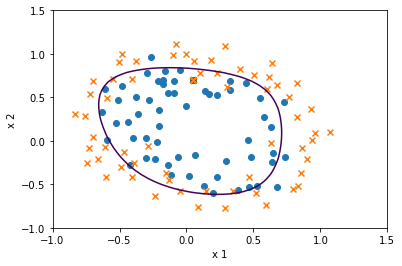

In [19]:
plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="y=1",marker ='o')
plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="y=0",marker ='x')
drawCircle()
plt.xlabel('x 1')
plt.ylabel('x 2')

Traçage du coût en fonction de theta0 et theta1

Text(0, 0.5, 'Cout')

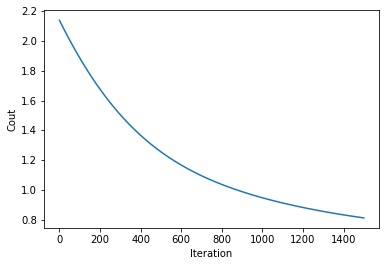

In [20]:
plt.plot(range(int(iterations/10)),vals[3::4][:int(iterations/10)])
plt.xlabel('Iteration')
plt.ylabel('Cout')

# Qualité du classifieur

Prédire des valeurs de y

Ici il serait interessant de calculer la précision de notre classifieur

Essayons de calculer ça avec 

moyenne(y==y-pred) * 100

Ceci donnera un pourcentage de precision

In [21]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(X,theta,0.5)
prcision = np.mean(y==y_pred)*100
print("Precision lambda = 1 ",prcision)
print("Precision lambda = 0 ",np.mean(y==predict(X,thet,0.5))*100)

Precision lambda = 1  82.20338983050848
Precision lambda = 0  82.20338983050848


# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 01 Avril 2022 à 22h


In [22]:
# bonne chance